In [85]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pydiffmap import diffusion_map as dm
import pandas as pd
import json

In [86]:
df = pd.read_csv('../data/processed/latent_vector_3_new.csv',header=None)
X = df.iloc[:, 0].values 
Y = df.iloc[:, 1].values
Z = df.iloc[:, 2].values 
latent_vectors = np.array([X, Y, Z]).transpose()
print(latent_vectors.shape)

(1138, 3)


In [87]:
# Estimate an appropriate epsilon value
epsilon_value = np.median([np.linalg.norm(x-y) for x in latent_vectors for y in latent_vectors])

# Initialize Diffusion Map object
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=50, epsilon=epsilon_value, alpha=1.0, neighbor_params=neighbor_params)

# Fit to data and return the diffusion map
dmap = mydmap.fit_transform(latent_vectors)
evals = mydmap.evals

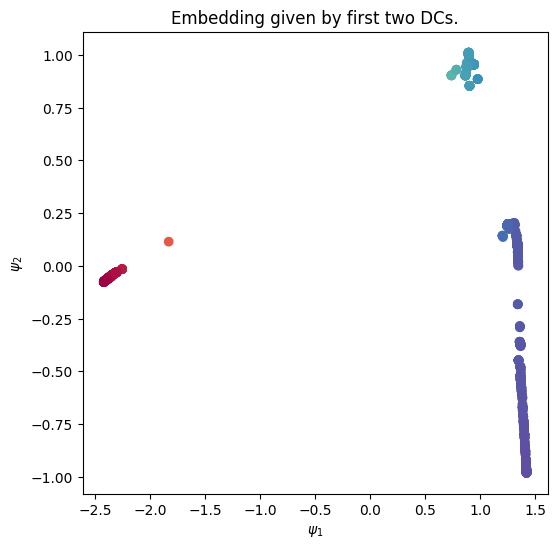

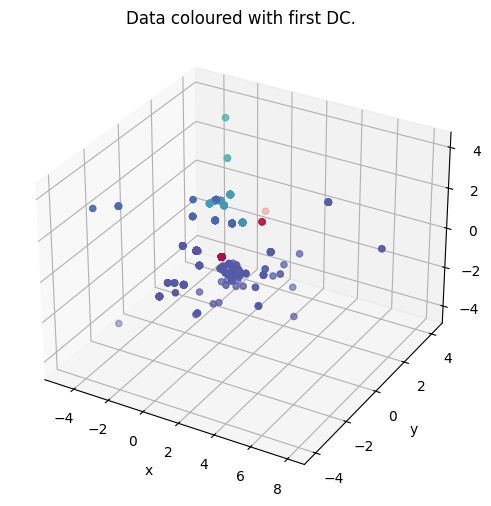

In [88]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'})
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()

In [89]:
# Print the diffusion coordinates and eigenvalues
print("Diffusion Coordinates Shape:", dmap.shape)
print("Eigenvalues:", evals)

Diffusion Coordinates Shape: (1138, 2)
Eigenvalues: [-0.0002773  -0.00348374]


In [90]:
with open("../data/processed/UN_data_with_narrative_answers.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)
labels = df['country'].to_list()
countries = df['country'].to_list()
years = df['year'].to_list()

# Load the latent vectors
df_vectors = pd.read_csv("../data/processed/latent_vector_3_new.csv", header=None)

#add the year and countries column to the latent vectors
df_vectors['year'] = years
df_vectors['country'] = countries

# Define the Euclidean distance function
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2)**2))

df_vectors['euclidean_distance'] = np.nan

for i, row in df_vectors.iterrows():
    current_vector = row[[0, 1, 2]].values
    current_year = row['year']
    current_country = row['country']
    us_vector = df_vectors[(df_vectors['year'] == current_year) & (df_vectors['country'] == 'USA')].iloc[0][[0, 1, 2]].values
    distance = euclidean_distance(current_vector, us_vector)
    df_vectors.at[i, 'euclidean_distance'] = f'{distance:.10f}'

# Define the diffusion distance function
def diffusion_distance(i, j, diffusion_coordinates, evals, t=1):
    distance_squared = np.sum([evals[k]**(2*t) * (diffusion_coordinates[i, k] - diffusion_coordinates[j, k])**2 
                               for k in range(len(evals))])
    distance = np.sqrt(distance_squared)
    return distance

# Create a new column 'diffusion_distance'
df_vectors['diffusion_distance'] = np.nan

for i, row in df_vectors.iterrows():
    current_year = row['year']
    current_country = row['country']
    index_i = i
    us_row = df_vectors[(df_vectors['year'] == current_year) & (df_vectors['country'] == 'USA')]
    
    if not us_row.empty:
        index_j = us_row.index[0]
        if index_i < len(dmap) and index_j < len(dmap):
            diff_distance = diffusion_distance(index_i, index_j, dmap, evals, t=1)
            df_vectors.at[i, 'diffusion_distance'] = f'{diff_distance:.10f}'
        else:
            print(f"Index out of bounds for diffusion map: {index_i}, {index_j}")
    else:
        print(f"USA data not found for year {current_year}")

/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_1648/2667328407.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2206112350' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_vectors.at[i, 'euclidean_distance'] = f'{distance:.10f}'
/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_1648/2667328407.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0033480072' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_vectors.at[i, 'diffusion_distance'] = f'{diff_distance:.10f}'


In [91]:
countries_of_interest = ["United States",
    "Afghanistan", "Albania", "Australia", "Azerbaijan", "Bulgaria", "Colombia",
    "Czechia", "Denmark", "El Salvador", "Eritrea", "Estonia", "Ethiopia",
    "Georgia", "Hungary", "Iceland", "Italy", "Japan", "Korea, Republic of", "Latvia",
    "Lithuania", "North Macedonia", "Netherlands", "Nicaragua", "Philippines", "Poland",
    "Romania", "Slovakia", "Spain", "Türkiye", "United Kingdom", "Uzbekistan",
    "Costa Rica", "Dominican Republic", "Honduras", "Kuwait", "Marshall Islands",
    "Micronesia, Federated States of", "Mongolia", "Palau", "Portugal", "Rwanda", "Singapore",
    "Solomon Islands", "Uganda", "Panama", "Angola", "Tonga", "Ukraine"
]

In [144]:
import pycountry
df_vectors_2003 = df_vectors[df_vectors['year'] == 2005]
top_30_countries = df_vectors_2003.sort_values('euclidean_distance',ascending=True).head(60)
country_names = {country.alpha_3: country.name for country in pycountry.countries}
top_30_countries['country'] = top_30_countries['country'].map(country_names)
top_30_countries['match'] = top_30_countries['country'].apply(lambda x: x in countries_of_interest)
#print where country = bahamas
top_30_countries[top_30_countries['country'] == "Cuba"]
#print without truncaiton 'Venezuela, Bolivarian Republic of', 'Benin', 'Kiribati', 'South Africa','
#pd.set_option('display.max_rows', None)
# Extract the 'country' column as a list
#country_list = top_30_countries['country'].tolist()

# Convert the list to a numpy array
#country_array = np.array(country_list)

# Print the array in the desired format
#print(f"array({country_array}, dtype=object)")
#top_30_countries

,0,1,2,year,country,euclidean_distance,diffusion_distance,match
268,-0.307014,0.533282,-0.911137,2005,Cuba,2.0647353903,0.0011041792,False


In [139]:
import pycountry
df_vectors_2003 = df_vectors[df_vectors['year'] == 2007]
top_30_countries = df_vectors_2003.sort_values('diffusion_distance',ascending=True).head(18)
country_names = {country.alpha_3: country.name for country in pycountry.countries}
top_30_countries['country'] = top_30_countries['country'].map(country_names)
top_30_countries['match'] = top_30_countries['country'].apply(lambda x: x in countries_of_interest)
#print where country = bahamas
#top_30_countries[top_30_countries['country'] == "Bhutan"]
#print without truncaiton 'Venezuela, Bolivarian Republic of', 'Benin', 'Kiribati', 'South Africa','
#pd.set_option('display.max_rows', None)
# Extract the 'country' column as a list
top_30_countries

,0,1,2,year,country,euclidean_distance,diffusion_distance,match
962,0.656029,-0.903049,2.091192,2007,North Macedonia,0.0000263321,0.0000000000,True
993,0.656029,-0.903040,2.091217,2007,United States,0.0000000000,0.0000000000,True
980,0.656033,-0.903043,2.091209,2007,United Kingdom,0.0000089323,0.0000000000,True
963,0.656026,-0.903046,2.091178,2007,Romania,0.0000393347,0.0000809047,True
1107,1.932007,1.191643,-0.540391,2007,Jordan,3.5973845126,0.0001838874,False
1047,1.932001,1.191640,-0.540387,2007,Kiribati,3.5973779175,0.0001838875,False
1018,1.932001,1.191640,-0.540387,2007,South Africa,3.5973779175,0.0001838875,False
1023,1.932001,1.191640,-0.540387,2007,"Venezuela, Bolivarian Republic of",3.5973779175,0.0001838875,False
1051,1.932001,1.191640,-0.540387,2007,Benin,3.5973779175,0.0001839008,False
1032,2.925337,0.680121,-1.053253,2007,Lao People's Democratic Republic,4.1885374315,0.0001935584,False


In [84]:
#df_vectors_to_csv
df_vectors.to_csv('../data/processed/latent_vector_3_with_diffusion_distances.csv', index=False)